In [1]:
# 시계열 분석
# 회귀분석과 시계열 분석은 거의 비슷하다

In [2]:
# 변동 
# > 추세(오차의 평균선), 계절(온도의 경우 파동형태), 순환(추세+계절), 불규칙
# > 추세(ARIMA), 계절, 순환(SARIMA), 불규칙(추세,계절,순환 제거 후 잔차활용)
# > 불규칙변동에서 잔차가 특정한 패턴을 갖지않는 분포라면 설명 안해도 됨
# > 추세,계절 변동으로 모든 변동을 설명할 수 있기 때문이다.
# > 모델이 적합하냐 안하냐는 불규칙변동을 통해 알 수 있다.(정상성과 잔차활용)

In [4]:
# 시계열 분해
# > 추세, 계절성, 잔차로 분해
# > 주기적 반복/계절성 존재 파악, 가법(완만한 상승세/계절성), 승법(가파른 상승세/계절성)
# > 추세, 계절성 분해 후 남은 잔차는 특정 패턴없이 무작위 분포를 띠고, 작은 값이어야 한다.
# > 만약 잔차의 특정 패턴이 존재한다면 잔차에 대해서만 다른 모형을 추가 적합 가능
# > 이는 이외의 다른 변인이 존재한다고 판단도 해야 된다.(ex, 잔차에 대해서만 회귀분석)

In [2]:
import pandas as pd
data = pd.read_csv('data/arima_data.csv', names = ['day', 'price'])
data.head(3)

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190


In [3]:
data.info() # ojbect > date 로 변경 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [4]:
data['day'] = pd.to_datetime(data['day'], format = '%Y-%m-%d')
data.set_index('day', inplace = True)
data.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2013-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   price   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

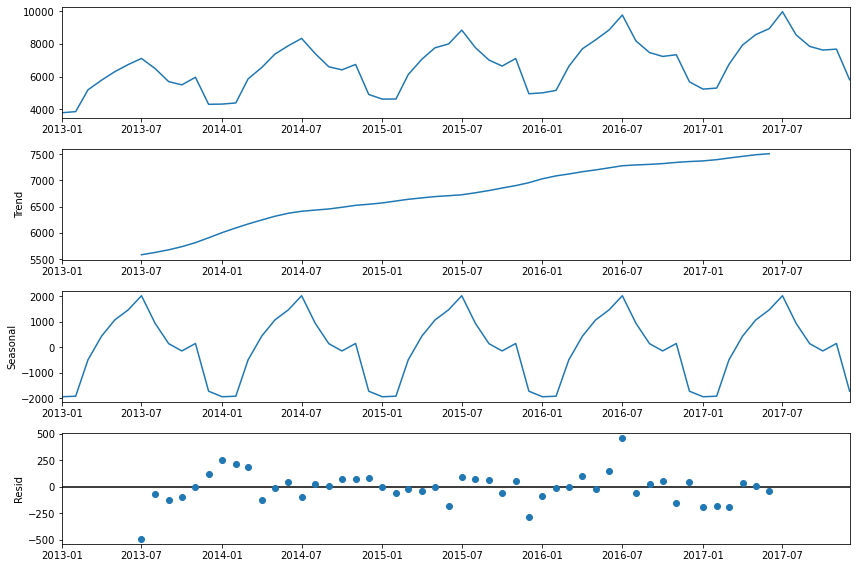

In [7]:
ts = data
result = seasonal_decompose(ts, model = 'additive')

plt.rcParams['figure.figsize'] = [12,8]
result.plot()
plt.show()

In [14]:
# 1 : 원본 데이터 기반 그래프
# 2 : 원본 데이터 기반 트렌드
# 3 : 2번에서 트렌드 제외한 계절성
# 4 : 2, 3 제외한 불규칙 요인

# 급격한 변화가 있지 않으므로, 가법 모형 적용 
# 계절성도 보이며
# 4번의 경우 잔차가 특정한 패턴을 보이지 않으며, 범위가 -250~250 인데
# 이는 원본 데이터에서 4000 ~ 10000이므로, 작은 부분에 해당
# 즉, 트렌드와 계절성에 잘 적합한 그래프이며 이는 시계열에 분석에 적합한 데이터이다
# 후에 정상성과 잔차분석을 통해 ARIMA 모델에 적용

In [15]:
# 정상성 검정 및 확인
# 추세와 계절성을 갖지 않는 진동하는 데이터 > 무작위성으로 진동하는 데이터
# 어떠한 시점에서도 동일한 모양이 나옴 
# 정상성을 갖춰야 ARIMA 모델로 적용가능하며,
# 정상성을 못갖췄다면 정상성을 갖춘 데이터로 변경 필요

# 귀무가설 : 데이터가 정상성을 갖지 않는다(변동이 있다.)
# 대립가설 : 데이터가 정상성을 갖는다

In [8]:
train_len = int(len(data)*0.8)
training = data[:train_len]
test = data.drop(training.index)

In [9]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(training, regression ='ct')
adf

(-1.9997199341327108,
 0.6015863303794554,
 10,
 37,
 {'1%': -4.226862411110892,
  '5%': -3.536645678834422,
  '10%': -3.200239967030581},
 571.2814574908573)

In [21]:
# 단위근 검정에서 P-value가 0.601이므로 즉, 0.05 보다 크므로, 정상성을 갖지 않는 것으로 판단됨.

In [23]:
# 차분 : 정상성을 갖지 않는다면 차분 수행 필요
# > 비정상성을 정상서으로 만들기 위해, 관측값들의 차이를 계산하는 것

<AxesSubplot:xlabel='day'>

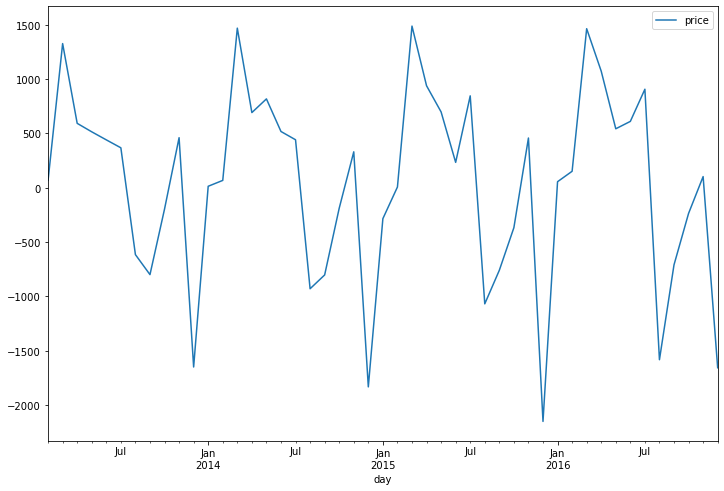

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data = training.diff(1) # 차분횟수 1
diff_data = diff_data.dropna()

diff_data.plot()

In [11]:
# 한 번 차분 후 정상성 검증
from statsmodels.tsa.stattools import adfuller
adf = adfuller(diff_data)
adf

(-12.094547576926429,
 2.085160639961008e-22,
 10,
 36,
 {'1%': -3.626651907578875,
  '5%': -2.9459512825788754,
  '10%': -2.6116707716049383},
 522.2910197373668)

In [34]:
# 차분 후 정상성을 갖는다. 만약 차분 후 정상성을 띄지 않는다면 2번 차분도 해보자

In [35]:
# ARIMA = AR +  I(DIFF, 차분) +  MA
# AR의 p값, MA의 q값을 구해야한다.
# AR : 몇 번째 이전의 데이터가 자신한테 가장 영향을 미치는가?
# > PACF 함수를 통해서 구함.
# MA : 몇 번의 평균, 몇 개의 이동평균을 구하는 것이 자신한테 가장 영향을 미치는가?
# > ACF 함수를 통해서 구함.

# > 0이 되기 이전의 값이 p,q가 되는 것이다.

C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


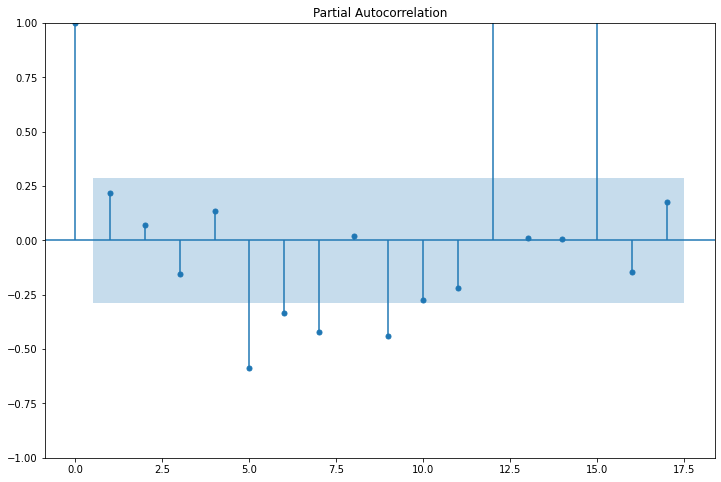

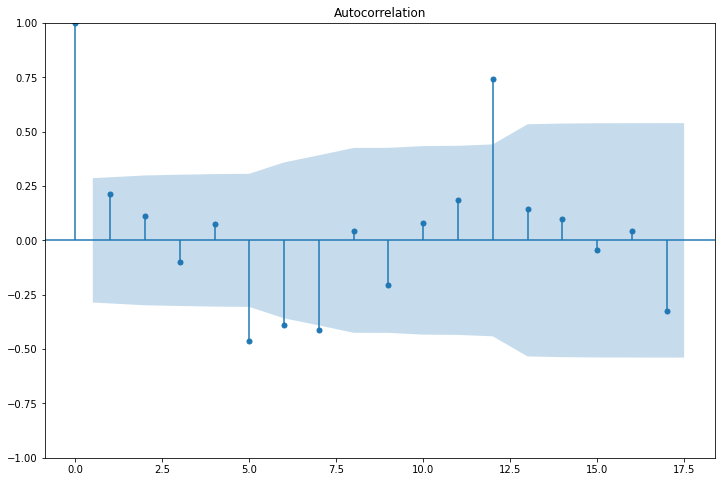

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  
import numpy as np
import matplotlib.pyplot as plt

plot_pacf(diff_data) # AR(p)의 값 확인 가능 == 2 
# > 3에서 -가 되며 절단점을 갖는다, 0을 만나기 전인 2이 p의 값이다.
plot_acf(diff_data) # MA(q)의 값 확인 가능 == 2
# > 3에서 -가 되며 절단점을 갖는다, 0을 만나기 전인 2이 q의 값이다.
plt.show()

In [13]:
# ARIMA 분석
training.price.values

array([3794, 3863, 5190, 5783, 6298, 6739, 7107, 6492, 5693, 5497, 5958,
       4309, 4323, 4391, 5860, 6552, 7370, 7888, 8330, 7401, 6599, 6411,
       6742, 4910, 4626, 4633, 6121, 7060, 7758, 7992, 8838, 7770, 7011,
       6644, 7102, 4952, 5008, 5160, 6624, 7697, 8240, 8851, 9758, 8176,
       7467, 7231, 7334, 5678], dtype=int64)

In [14]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

model = ARIMA(training.price.values, order = (2,1,2))
res = model.fit()
res.summary()
# Model : p,d,q 확인
# AIC / BIC : 회귀분석과 비슷
# ar.L1 바로 직전의 값이 영향
# z분포 활용

C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -375.875
Date:                Thu, 29 Sep 2022   AIC                            761.751
Time:                        11:07:54   BIC                            771.001
Sample:                             0   HQIC                           765.232
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3165      0.191     -6.897      0.000      -1.691      -0.942
ar.L2         -0.3189      0.192     -1.664      0.096      -0.695       0.057
ma.L1          1.9687      0.245      8.035      0.000       1.489       2.449
ma.L2          0.9936      0.244      4.077      0.000       0.516       1.471
sigma2      4.462e+05   1.16e-06   3.86e+11      0.000    4.46e+05    4.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.74   Prob(JB):                         0.83
Heteroskedasticity (H):               1.49   Skew:                            -0.21
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.77e+26. Standard errors may be unstable.
"""

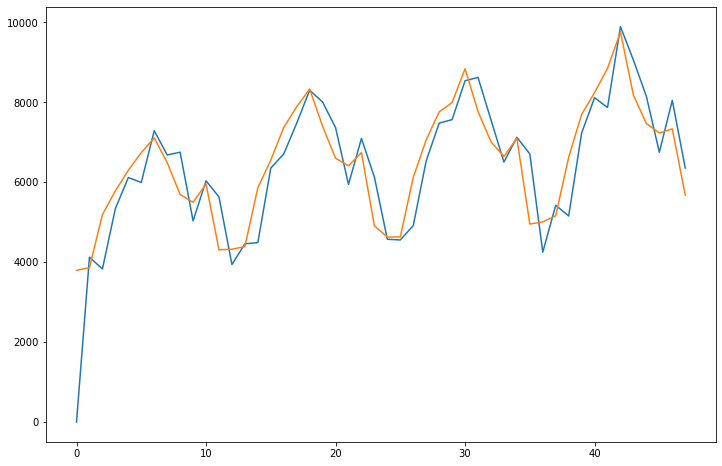

In [15]:
plt.plot(res.predict()) # 파란색 : 예측값
plt.plot(training.price.values) # 주황색 : 원본 데이터

In [16]:
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
forecast_data = res.forecast(steps=len(test), alpha = 0.1) 
pred_y = forecast_data.tolist()
pred_y

[5830.098518394034,
 5507.962799984046,
 5883.561498968603,
 5491.803778062671,
 5887.785439341294,
 5491.396120380681,
 5886.975064779788,
 5492.593019697496,
 5885.657736881482,
 5493.945628740168,
 5884.297085085191,
 5495.305617511607]

In [17]:
test_y = test.values
test_y

array([[5236],
       [5299],
       [6744],
       [7927],
       [8561],
       [8930],
       [9960],
       [8548],
       [7843],
       [7620],
       [7676],
       [5809]], dtype=int64)

In [18]:
# pred_y, test_y의 차이 RMSE
# 모형의 적합도는 r^2 확인

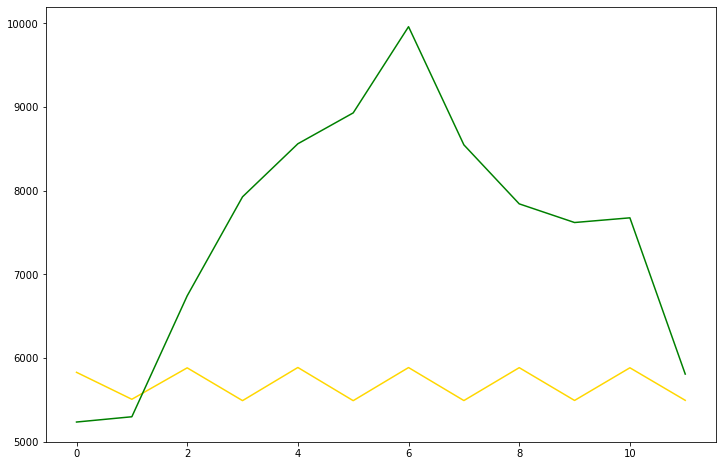

In [19]:
plt.plot(pred_y, color = 'gold') # 모형이 예상한 가격 그래프
plt.plot(test_y, color = 'green') # 실제 가격 그래프

In [54]:
# 예상과 실제가 다르다? ARIMA 모델은 추세만 반영하고 계절성을 반영하지 못한다.
# 이러한 문제를 해결하기 위해 SARIMA 모델 활용(추세, 계절성 반영)

In [20]:
from sklearn.metrics import r2_score
r2_score(pred_y, test_y)

-144.2482160790695

In [21]:
regid = pred_y-test_y

In [22]:
import numpy as np
np.sqrt(np.sum(regid**2)/len(test_y))

8034.270939513101

In [1]:
# SARIMA : 계절성(주기에 따라 유사한 양상으로 변화하는 모양)까지 고려한 ARIMA 모델
# ARIMA는 거의 사용 X

In [36]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/arima_data.csv', names = ['day', 'price'])
data['day'] = pd.to_datetime(data['day'],format="%Y-%m-%d")
data.set_index('day', inplace=True)
s_data = data


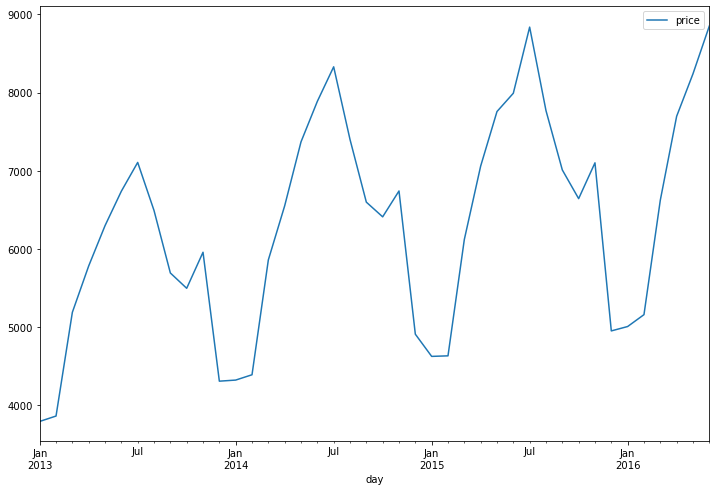

In [51]:
train_len = int(len(s_data) * 0.7)
training = s_data[:train_len]
test = s_data.drop(training.index)


import matplotlib.pyplot as plt
training.plot()
plt.show()

In [52]:
model = SARIMAX(training.price.values, 
                  order=(2,1,2), 
                  seasonal_order=(1,1,1,12), # 계절성을 잘 표현하는 2,1,2 와 P/D/Q 조합
                  trend='ct',
                 # 아래 그래프 오류 현상 해결(statsmodels 0.11.1로 변경 필요), True로 변경
                  enforce_stationarity=True, # order을 고정시키기 위함
                  enforce_invertibility=True) # order을 고정시키기 위함

results = model.fit()
results.summary()

C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\KDB\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   42
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -191.340
Date:                              Thu, 29 Sep 2022   AIC                            400.680
Time:                                      11:39:54   BIC                            412.986
Sample:                                           0   HQIC                           404.534
                                               - 42                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -266.3708   1290.064     -0.206      0.836   -2794.850    2262.108
drift         10.2242     40.143      0.255      0.799     -68.455      88.904
ar.L1         -1.8041      0.419     -4.303      0.000      -2.626      -0.982
ar.L2         -0.9638      0.353     -2.731      0.006      -1.655      -0.272
ma.L1          1.7655     22.701      0.078      0.938     -42.728      46.260
ma.L2          0.9979     25.540      0.039      0.969     -49.059      51.055
ar.S.L12      -0.9957      4.835     -0.206      0.837     -10.471       8.480
ma.S.L12       0.9842      9.509      0.104      0.918     -17.654      19.622
sigma2      2.899e+04   7.18e+05      0.040      0.968   -1.38e+06    1.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.71   Prob(JB):                         0.73
Heteroskedasticity (H):               0.85   Skew:                             0.13
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.24e+14. Standard errors may be unstable.
"""

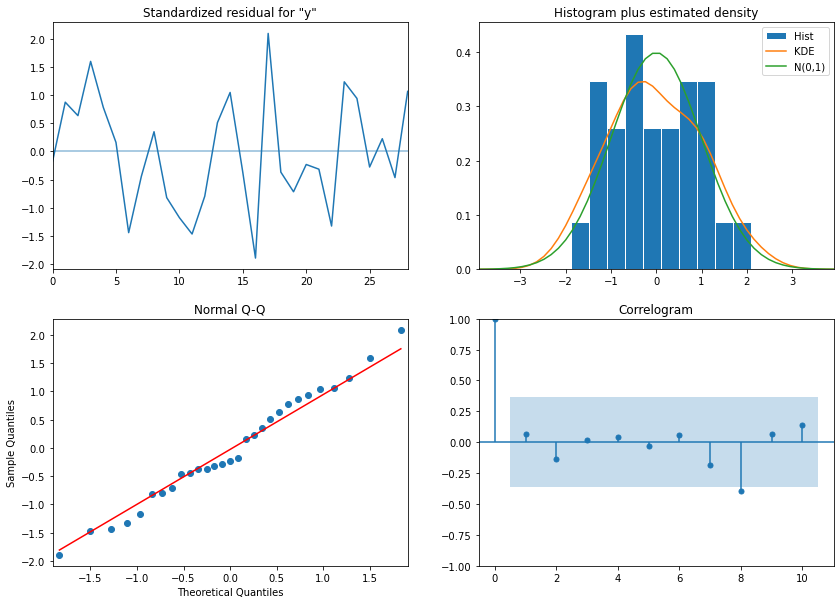

In [53]:
# 데이터 확인(위의 표는 별로 해석할 것이 없다.)
results.plot_diagnostics(figsize=(14, 10)) # plot_diagnostics 잔차의 특정 패턴을 가지고 있는지?
plt.show()

In [54]:
# 예측값, mse, 신뢰구간의 최소 & 최대값
forecast_values = results.get_forecast(steps = len(test))
forecast_values.summary_frame()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,9547.271413,176.161179,9202.001846,9892.540980
1,8670.921065,238.586492,8203.300134,9138.541996
2,7813.625264,301.965290,7221.784172,8405.466357
3,7558.941786,339.911217,6892.728043,8225.155529
4,8030.632337,387.001197,7272.123929,8789.140745
5,5865.194586,419.042839,5043.885714,6686.503457
6,6044.760290,454.766292,5153.434736,6936.085844
7,6085.066539,485.922246,5132.676438,7037.456639
8,7740.046589,513.405458,6733.790382,8746.302795
9,8710.005743,544.377857,7643.044749,9776.966737


In [55]:
# 예측값을 그리는 함수
forecast_values.conf_int()

array([[ 9202.00184581,  9892.54098026],
       [ 8203.30013413,  9138.54199615],
       [ 7221.78417186,  8405.46635693],
       [ 6892.72804348,  8225.15552853],
       [ 7272.12392859,  8789.14074473],
       [ 5043.88571362,  6686.50345749],
       [ 5153.4347357 ,  6936.08584414],
       [ 5132.6764378 ,  7037.45663946],
       [ 6733.79038238,  8746.30279493],
       [ 7643.04474872,  9776.96673693],
       [ 8287.81312819, 10510.55212371],
       [ 8809.14809152, 11146.16652897],
       [ 9398.67379768, 12072.63092422],
       [ 8472.87135295, 11453.90511953],
       [ 7423.03181162, 10701.54165089],
       [ 7226.93852644, 10740.15898125],
       [ 7494.40386492, 11276.78863775],
       [ 5404.4513203 ,  9387.70206391]])

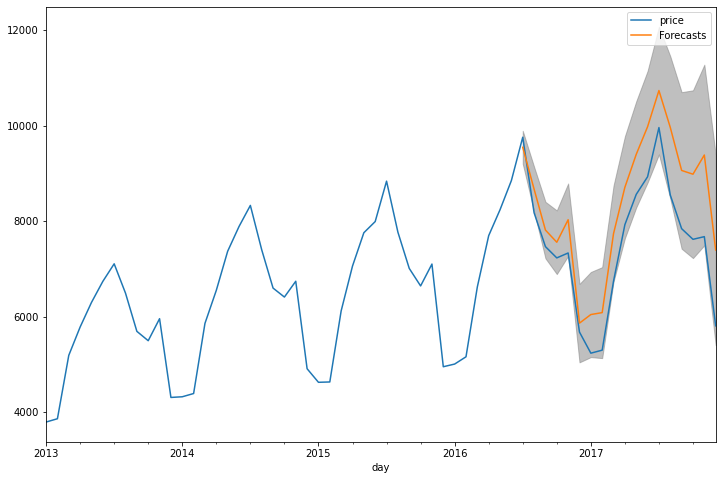

In [57]:
ax = s_data.plot()
pred_ci = pd.DataFrame(forecast_values.conf_int())
pred_ci.index = list(test.index)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:,0],
                pred_ci.iloc[:,1],
                color = 'gray',
                alpha = 0.5)

predicted = pd.DataFrame(forecast_values.predicted_mean)
predicted.index = list(test.index)
predicted.columns = ['Forecasts']
predicted.plot(ax=ax, label = 'Forecasts')

plt.legend()
plt.show()

In [58]:
from sklearn.metrics import r2_score
r2_score(predicted, test)

# 강의상 20% 설명력이며, 비슷하게 예측하는 것처럼 보이지만,
# 사실은 신뢰구간에도 들어오지 않고, 

0.5053241058661928